<img src="https://www.mmu.edu.my/fci/wp-content/uploads/2021/01/FCI_wNEW_MMU_LOGO.png" style="height: 80px;" align=left>  

# Learning Objectives

Towards the end of this lesson, you should be able to:
- perform clustering using K-means
- evaluate clustering results using external measures




---



### For Google Colab Use Only
Skip this section if you are using Jupyter Notebook etc.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# drive_path = '/content/drive/MyDrive/Trimester/2310/TDS3301/Tutorials/Tutorial 10/' #set your google drive path

---

# Cluster Analysis
Clustering or data segmentation is the task to partition a given set of data points (dataset) into a set of groups (i.e., clusters) which are as similar as possible. It is fundamentally an unsupervised learning task with no predefined classes to guide the grouping.

The key to clustering is similarity / dissimilarity of the data points. A good clustering outcome has 2 criteria:
1. Data points within / inside the same cluster has high similarity / low distance to indicate a cohesive cluster (high intra-class similarity).
2. Data points between / across different clusters has low similarity / high distance to indicate distinctive cluster (low inter-class similarity).

## k-Means Clustering

k-Means is a partition type clustering algorithm. Using similarity/distrance measures, data points are clustered based on centroids that are iteratively updated. Comparatively, k-Means is an efficient clustering method to produce convex-shaped groups of data.

The [`scikit-Learn`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) package provides 2 versions of the approach, the general k-Means, and a modified version called, Bisecting k-Means.

The following experiments lets you try out k-Means clustering on the `diabetes.csv` dataset that has been used various times previously.

---

## Data Preprocessing

The following steps of preprocessing are replicated from the previous tutorial.

In [3]:
#import the relevant libraries
import pandas as pd #data reading
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # label encoding
from sklearn.model_selection import train_test_split # Import train_test_split function
import seaborn as sns
import numpy as np

#code to ensure path
try:
  drive_path
except NameError:
  drive_path = ''

# load diabetes.csv dataset
df = pd.read_csv(drive_path + "diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The `diabetes.csv` dataset contains fully numerical data. <br>


In [4]:
# check the data types
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Additionally, let's have a look at the distribution among the various attributes to see of at apparent partitioning.

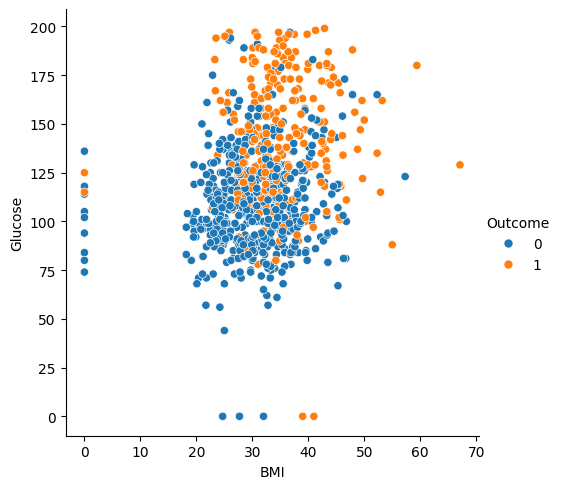

In [5]:
sns.relplot(x="BMI", y="Glucose", hue="Outcome", data=df)
plt.show()

For clustering, we do not need target classes for training, however, we still use the class labels in 2 ways:
1. As another attribute for clustering (exploring inherent data groupings)
2. As reference groundtruth to evaluate clustering performance (external measures)

We will be using class labels for evaluation later, so let's split the dataset attributes and class labels into their own variables, and then create the training, validation, and testing sets as we did in classification tasks. <br>
*Note*: The `train_test_split` function does not provide a direct train/val/test split, so we can split the dataset twice to create the 3 sets.

In [6]:
#split dataset in features and target variable*
# feature_cols = ['Pregnancies', 'Insulin', 'BMI', 'Age','Glucose','BloodPressure','DiabetesPedigreeFunction']
X = df.drop('Outcome',axis=1) #Features
y = df.Outcome # Target variable
print(X.shape)
print(y.shape)

(768, 8)
(768,)


In [7]:
#First split to get 20% as test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)
#Split the training set again to get the validation set (requires calculation the get the needed percentage)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1, stratify=y_train)
# 12.5% of 80% is 10% of the whole dataset (0.125 x 0.8 = 0.1)

print('Training set: ', y_train.shape)
print('Validation set: ', y_val.shape)
print('Testing set: ', y_test.shape)


Training set:  (537,)
Validation set:  (77,)
Testing set:  (154,)


As k-Means clustering uses similarity / distance measures, the training data needs to be normalized as well to ensure no bias in the features during model training.

In [8]:
#normalize the training data
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)


End of data preprocessing

---

## Training and Evaluation

With the ready datasets, we can create and train a k-Means model. To start, let's setup the k-Means clustering method with 2 clusters.<br>
By default, the implementation uses `k-means++` initialization.

In [9]:
from sklearn.cluster import KMeans

# the number of clusters here is 2

km = KMeans(n_clusters = 2, random_state=1)
km.fit(X_train_norm)

KMeans(n_clusters=2, random_state=1)

After training, we can extract the "labels" from the model. These labels are not exactly the classes as normally produced by classifiers. The labels here are mainly indicating the clusters produced. To actually identify the "classes", we would need to map them based on majority by referring to the target classes of the dataset (`y`) later.

In [10]:
print(km.labels_)

[0 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1
 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0
 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0
 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0
 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1
 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0 1 0 0 1 1
 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1
 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 0 0
 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1
 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1
 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1
 0 1 1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0
 1 0 1 0 0 0 0 1 1 0 0 0 

For now, let's visualize the clustered outcome again to observe the differences. Firstly, merge the cluster labels with the training attributes:

In [11]:
#Merge training set
df_train = X_train.copy()
df_train['Outcome']=y_train
#Merge cluster set
df_train_clustered = X_train.copy()
df_train_clustered['Cluster_kmeans']=km.labels_

Visualize the ground truth labels of the training data and the clustered labels side-by-side for comparison.

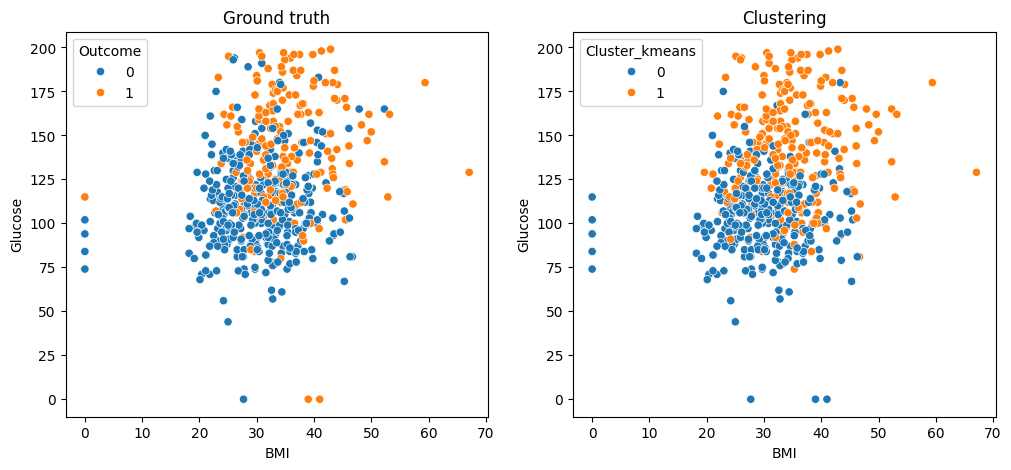

In [12]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.scatterplot(x="BMI", y="Glucose", hue="Outcome", data=df_train, ax=axes[0]).set( title='Ground truth')
sns.scatterplot(x="BMI", y="Glucose", hue="Cluster_kmeans", data=df_train_clustered,ax=axes[1]).set(title='Clustering')
plt.show()

Notice that the most of the data points have been clustered similarly to the original data.

To use the trained model, just apply it using `predict`.

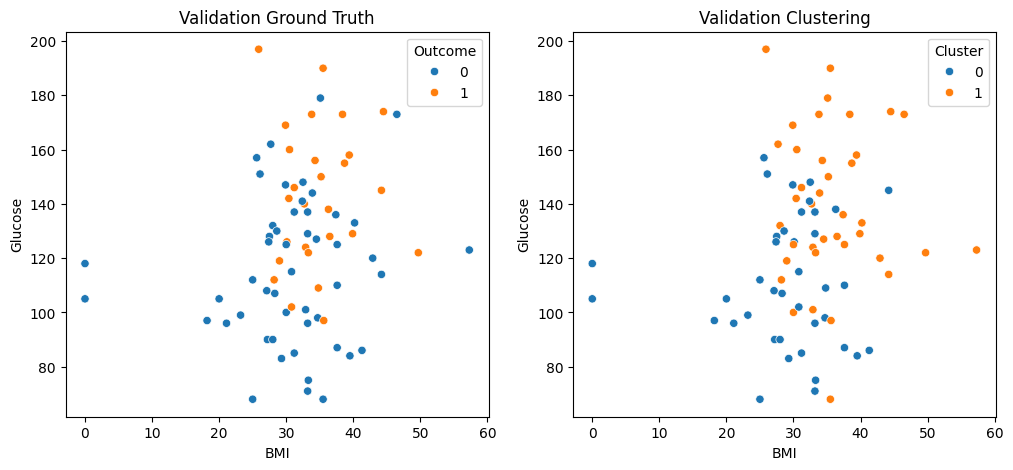

In [13]:
X_val_norm = scaler.transform(X_val)
val_cluster = km.predict(X_val_norm)

#Merge training set
df_val = X_val.copy()
df_val['Outcome']=y_val
#Merge cluster set
df_val_clustered = X_val.copy()
df_val_clustered['Cluster']=val_cluster

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.scatterplot(x="BMI", y="Glucose", hue="Outcome", data=df_val, ax=axes[0]).set( title='Validation Ground Truth')
sns.scatterplot(x="BMI", y="Glucose", hue="Cluster", data=df_val_clustered,ax=axes[1]).set(title='Validation Clustering')
plt.show()



---

### Determining k value

Unlike the previous example, clustering may also be done without any reference labels in order to explore for unknown groupings within data. In such cases, determining the k for partition-based clustering can be crucial.

A popular approach to infer the optimum k is using the "Elbow Method". Multiple k-Means models are trained using different k values, and the resultant Sum of Squared Distances (SSD) are used to generate a plot of SSD vs. k. Using the plot, we identify the best k at the "elbow".

Let's identify the best k from the previous dataset by testing 1 to 20 clusters.We can extract the SSD from the trained k-Means model from the `inertia` attributes.

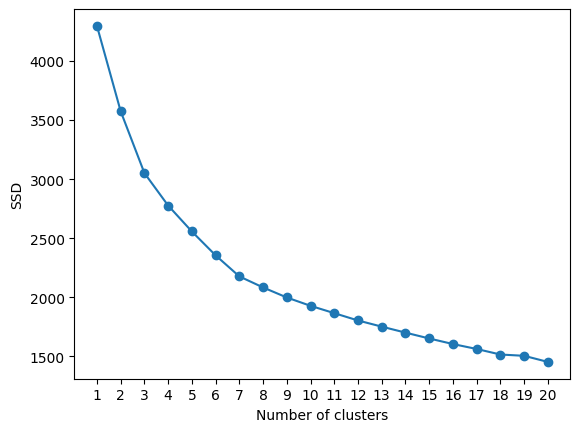

In [14]:
max_k = 20
ssd = []
for i in range(1, max_k+1):
    km_elbow = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km_elbow.fit(X_train_norm)
    ssd.append(km_elbow.inertia_)#Sum of squared distances of samples to their closest cluster center

# plot
plt.plot(range(1, max_k+1), ssd, marker='o')
plt.xticks(range(1, max_k+1))
plt.xlabel('Number of clusters')
plt.ylabel('SSD')
plt.show()

The best k for this case seem to be 7.

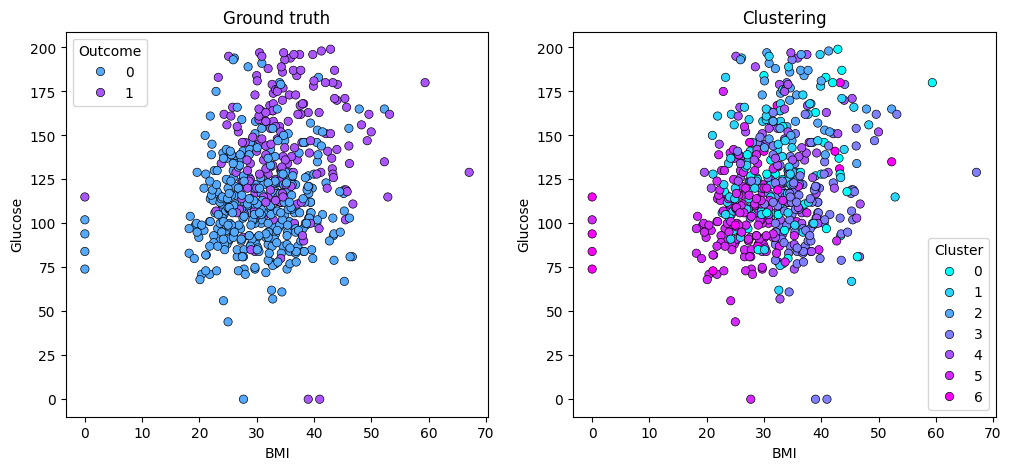

In [15]:
km_best = KMeans(n_clusters = 7, random_state=1, n_init = 10)
km_best.fit(X_train_norm)

#Merge cluster set
df_best = X_train.copy()
df_best['Cluster']=km_best.labels_

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.scatterplot(x="BMI", y="Glucose", hue="Outcome", data=df_train, ax=axes[0], palette='cool',edgecolor="black").set( title='Ground truth')
sns.scatterplot(x="BMI", y="Glucose", hue="Cluster", data=df_best,ax=axes[1], palette='cool',edgecolor="black").set(title='Clustering')
plt.show()

---

### pyclustering Package

The k-Means implementation in scikit-learn is very basic and it does not provide much flexibility in tuning parameters. For instance, the distance metric is hard-set as Euclidean Distance. For alternative methods, there are various other packages that provides more flexibility and also implementation of other variants of this clustering approach.

Let's try the [`pyclustering` package](https://pyclustering.github.io/docs/0.10.1/html/index.html):



In [16]:
!pip install pyclustering

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
     ---- ----------------------------------- 0.3/2.6 MB 8.6 MB/s eta 0:00:01
     -------------- ------------------------- 1.0/2.6 MB 12.1 MB/s eta 0:00:01
     ------------------------------- -------- 2.0/2.6 MB 16.2 MB/s eta 0:00:01
     ---------------------------------------- 2.6/2.6 MB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395134 sha256=2b966d5bec35720b8253cc9325c02e7e7e485431508f6710c06f30e39f7f34f9
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\9f\99\15\e881f46a92690ae77c2e3b255b89ea45d3a867b1b6c2ab3ba9
Successfully built pyclustering


Here, we are going to re-implement the same process of the k-Means using `pyclustering`.<br>
The general process is exactly the same, just different syntax:

In [17]:
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
# Prepare initial centers using K-Means++ method.
initial_centers = kmeans_plusplus_initializer(X_train_norm, 2).initialize()

# Create instance of K-Means algorithm with prepared centers.
kmeans_instance = kmeans(X_train_norm, initial_centers,ccore=False)

# Run cluster analysis and obtain results.
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()
final_centers = kmeans_instance.get_centers()

print(initial_centers)
print(clusters)
print(final_centers)

[array([ 1.51594392, -2.00083654,  0.60812554,  1.01188712, -0.72279144,
        0.08675926, -1.149571  ,  0.67475755]), array([-0.54125218,  2.37879693,  0.04343003,  4.89722557, -0.72279144,
        0.335762  ,  0.32231545,  2.48475776])]
[[0, 3, 5, 6, 7, 9, 13, 14, 18, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 42, 43, 44, 46, 48, 49, 51, 52, 53, 54, 56, 57, 59, 61, 63, 64, 66, 69, 71, 72, 73, 76, 77, 79, 80, 85, 86, 88, 90, 91, 93, 94, 96, 97, 98, 99, 100, 104, 105, 106, 107, 108, 109, 110, 112, 113, 116, 117, 118, 119, 120, 121, 124, 125, 126, 127, 128, 132, 133, 134, 136, 137, 140, 141, 142, 143, 145, 146, 149, 150, 154, 158, 161, 162, 164, 169, 171, 172, 173, 175, 176, 178, 180, 182, 184, 186, 187, 188, 189, 190, 191, 192, 194, 195, 196, 198, 199, 200, 202, 203, 206, 207, 208, 209, 210, 212, 214, 216, 218, 219, 222, 223, 224, 225, 226, 227, 229, 230, 236, 237, 238, 239, 241, 245, 246, 247, 251, 255, 256, 257, 258, 259, 261, 262, 263, 264, 268, 270, 271, 273,

The clustering output (`clusters`) of the k-Means using pyclustering is formatted differently from scikit-learn. Instead of the full list of labels, it returns the indices of clustered data points, sorted in lists.

For quick conversion, we can use the function below:

In [18]:
def cluster_pyc2skl(labels_list,py_clusters):
  cluster_skform = np.zeros(len(labels_list))
  cluster_list = range(len(py_clusters))
  cluster_num = 0
  for i in py_clusters:
    for j in i:
      cluster_skform[j] = cluster_num
    cluster_num += 1
  return cluster_skform

pyc_cluster = cluster_pyc2skl(y_train,clusters)
print(pyc_cluster)

[0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0.
 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.

Now we can merge with the attributes and visualize the clustering using this alternative package:

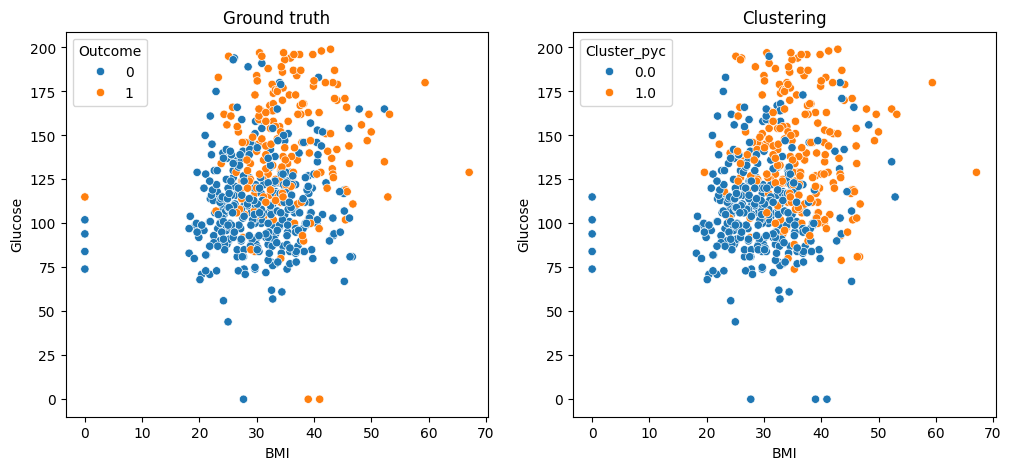

In [19]:
#Append results to the dataframe for visualization
df_train_clustered['Cluster_pyc']= pyc_cluster

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.scatterplot(x="BMI", y="Glucose", hue="Outcome", data=df_train, ax=axes[0]).set( title='Ground truth')
sns.scatterplot(x="BMI", y="Glucose", hue="Cluster_pyc", data=df_train_clustered,ax=axes[1]).set(title='Clustering')
plt.show()

Notice that the outcome is similar (minor differences due to intialization).<br> Let's check the validation set:

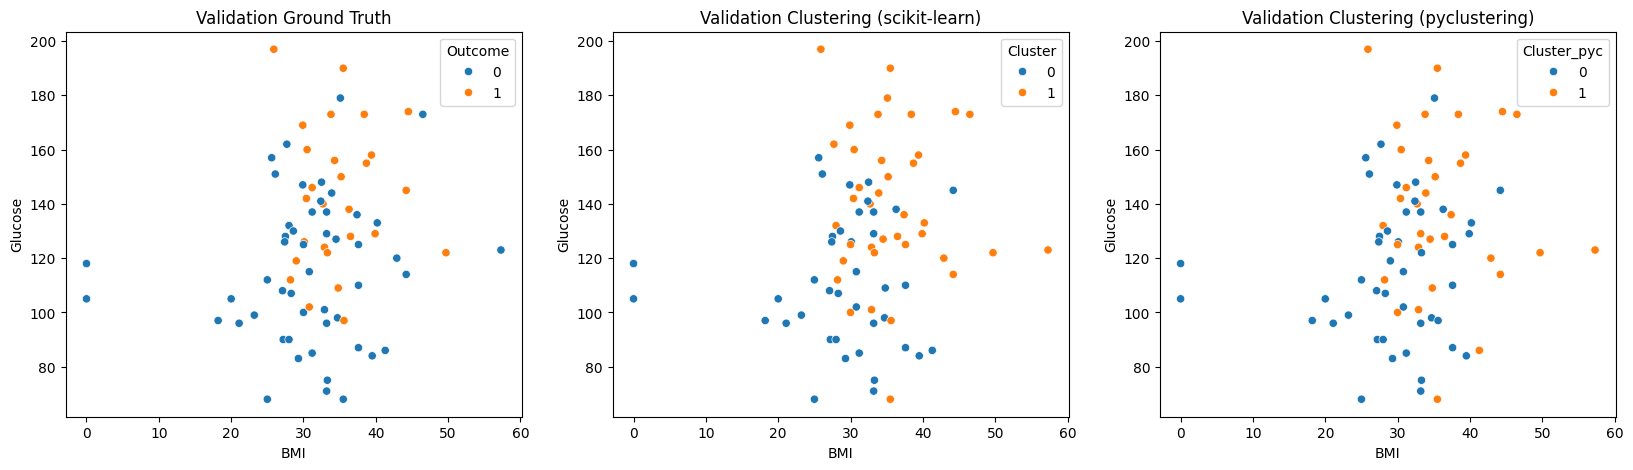

In [20]:
val_pyc_clusters = kmeans_instance.predict(X_val_norm)

#Merge cluster set
df_val_clustered['Cluster_pyc']=val_pyc_clusters

_, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
sns.scatterplot(x="BMI", y="Glucose", hue="Outcome", data=df_val, ax=axes[0]).set( title='Validation Ground Truth')
sns.scatterplot(x="BMI", y="Glucose", hue="Cluster", data=df_val_clustered,ax=axes[1]).set(title='Validation Clustering (scikit-learn)')
sns.scatterplot(x="BMI", y="Glucose", hue="Cluster_pyc", data=df_val_clustered,ax=axes[2]).set(title='Validation Clustering (pyclustering)')
plt.show()

For different outcomes, we have the flexibility to change the [distant metric](https://pyclustering.github.io/docs/0.10.1/html/df/df9/classpyclustering_1_1utils_1_1metric_1_1distance__metric.html) using this package, for instance using the Minkowski distance formulation for different degree of distances.

The following is an example of implementing k-means using different distance:


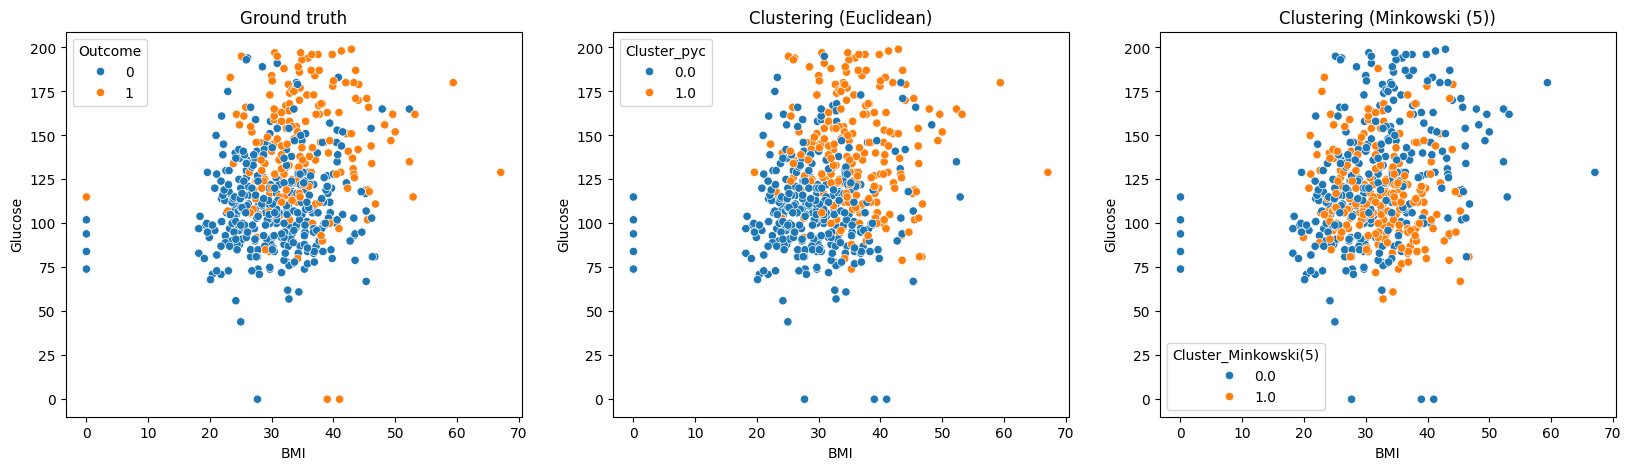

In [21]:
from pyclustering.utils.metric import distance_metric, type_metric #import methods for metrics
metric = distance_metric(type_metric.MINKOWSKI, degree=5)

# create instance of K-Means using specific distance metric:
kmeans_minkowski = kmeans(X_train_norm, initial_centers, metric=metric) #using same initial centers from previous test

# run cluster analysis and obtain results
kmeans_minkowski.process()
clusters_minkowski = kmeans_minkowski.get_clusters()

# convert clustering outcomes to sklearn format
clusters_minkowski = cluster_pyc2skl(y_train,clusters_minkowski)

# visualize outcomes
df_train_clustered['Cluster_Minkowski(5)']= clusters_minkowski

_, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
sns.scatterplot(x="BMI", y="Glucose", hue="Outcome", data=df_train, ax=axes[0]).set( title='Ground truth')
sns.scatterplot(x="BMI", y="Glucose", hue="Cluster_pyc", data=df_train_clustered,ax=axes[1]).set(title='Clustering (Euclidean)')
sns.scatterplot(x="BMI", y="Glucose", hue="Cluster_Minkowski(5)", data=df_train_clustered,ax=axes[2]).set(title='Clustering (Minkowski (5))')
plt.show()

The clusters may change significantly when different metrics are used.

---

## Variants of k-Means

While k-Means by itself is very efficient and mostly useful, it is prone to outliers, as noticeable from the previous examples. `pyclustering` provides the k-Medoids and k-Medians version of the method which are not available in scikit-learn.

### k-Medoids
The k-Medoids appraoch to handle the outlier issue in k-Means but using actual data points as centroids, instead of the computed value.

Let's re-implement the previous clustering and compare them:

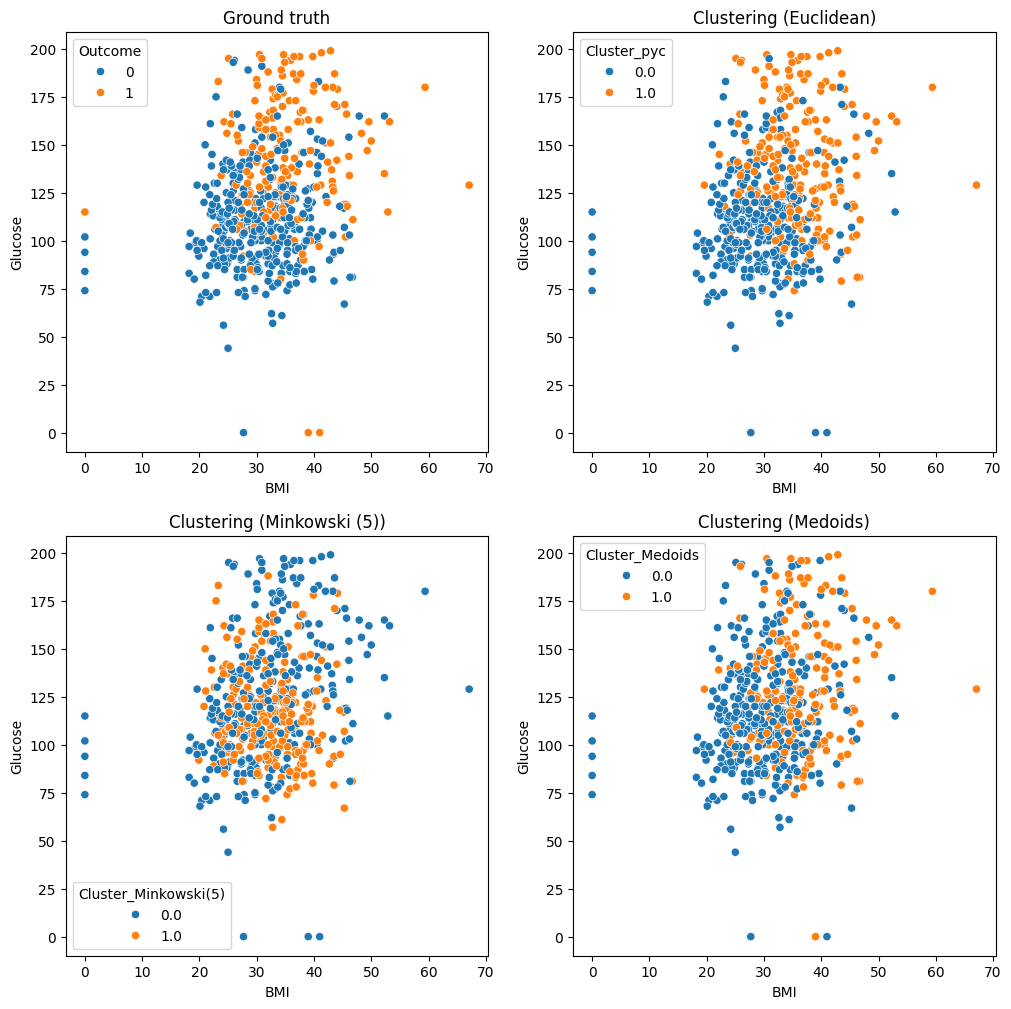

In [22]:
from pyclustering.cluster.kmedoids import kmedoids

# Initialize initial medoids using K-Means++ algorithm
initial_medoids = kmeans_plusplus_initializer(X_train_norm, 2).initialize(return_index=True)

# Create instance of K-Medoids (PAM) algorithm.
kmedoids_instance = kmedoids(X_train_norm, initial_medoids)

# Run cluster analysis and obtain results.
kmedoids_instance.process()
clusters_medoids = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

# convert clustering outcomes to sklearn format
clusters_medoids = cluster_pyc2skl(y_train,clusters_medoids)

# visualize outcomes
df_train_clustered['Cluster_Medoids']= clusters_medoids

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
sns.scatterplot(x="BMI", y="Glucose", hue="Outcome", data=df_train, ax=axes[0,0]).set( title='Ground truth')
sns.scatterplot(x="BMI", y="Glucose", hue="Cluster_pyc", data=df_train_clustered,ax=axes[0,1]).set(title='Clustering (Euclidean)')
sns.scatterplot(x="BMI", y="Glucose", hue="Cluster_Minkowski(5)", data=df_train_clustered,ax=axes[1,0]).set(title='Clustering (Minkowski (5))')
sns.scatterplot(x="BMI", y="Glucose", hue="Cluster_Medoids", data=df_train_clustered,ax=axes[1,1]).set(title='Clustering (Medoids)')
plt.show()



The package also provides other methods. Feel free to explore them in the documentations.

---

### Exercise
Cluster the testing set using all the previously trained models, and visualize the results.


---

## Clustering Evaluations

Evaluation is a very important aspect of data mining, and machine learning. Clustering outcomes can be evaluated in various ways, with of without reference labels / ground truth. We will now explore the evaluation metrics that makes use of the dataset target labels / ground truth.


### Rand Index
Rand index is a function that measures the similarity of the two assignments, ignoring permutations, i.e. it does not consider the position / index of the clustered points' labels (for classification, permutation must be included to ensure correct samples are being compared). Rand index outputs evaluation scores with the range of [0,1] where 1 indicates perfect clustering outcome.

Let's compare all the method's training outcomes using Rand Index:

In [23]:
from sklearn.metrics import rand_score

rand_skl_kmeans = rand_score(y_train, km.labels_)
rand_pyc_kmeans = rand_score(y_train, pyc_cluster)
rand_minkowski_kmeans = rand_score(y_train, clusters_minkowski)
rand_kmedoids = rand_score(y_train,clusters_medoids)

print('Rand index')
print('k-Means: Euclidean (scikit-learn): ',rand_skl_kmeans)
print('k-Means: Euclidean (pyclustering): ',rand_pyc_kmeans)
print('k-Means: Minkowski5 (pyclustering): ',rand_minkowski_kmeans)
print('k-Medoids (pyclustering): ',rand_kmedoids)

Rand index
k-Means: Euclidean (scikit-learn):  0.5901637066066316
k-Means: Euclidean (pyclustering):  0.5572417243391978
k-Means: Minkowski5 (pyclustering):  0.5017093304427582
k-Medoids (pyclustering):  0.5182189610606187


What is the best performing method?

### Homogeinity, Completeness, and V-measure
Alternatively, the ground truth is also commonly used to evaluate the extent of match between the assigned clusters of the data points with the given target labels.

In particular, the 3 metrics can be used:
* **Homogeneity**: each cluster contains only members of a single class.
* **Completeness**: all members of a given class are assigned to the same cluster.
* **V-measure**: The harmonic mean of homogeneity and completeness.

All 3 measures are in the range of [0,1] where closer to 1 indicates better performance. <br>
Try them out on the training set:

In [24]:
from sklearn.metrics import homogeneity_score

homo_skl_kmeans = homogeneity_score(y_train, km.labels_)
homo_pyc_kmeans = homogeneity_score(y_train, pyc_cluster)
homo_minkowski_kmeans = homogeneity_score(y_train, clusters_minkowski)
homo_kmedoids = homogeneity_score(y_train,clusters_medoids)

print('Homogeneity Score')
print('k-Means: Euclidean (scikit-learn): ',homo_skl_kmeans)
print('k-Means: Euclidean (pyclustering): ',homo_pyc_kmeans)
print('k-Means: Minkowski5 (pyclustering): ',homo_minkowski_kmeans)
print('k-Medoids (pyclustering): ',homo_kmedoids)

Homogeneity Score
k-Means: Euclidean (scikit-learn):  0.13025625525652126
k-Means: Euclidean (pyclustering):  0.07196578402784679
k-Means: Minkowski5 (pyclustering):  0.013159866400886773
k-Medoids (pyclustering):  0.013696911656476829


In [25]:
from sklearn.metrics import completeness_score

comp_skl_kmeans = completeness_score(y_train, km.labels_)
comp_pyc_kmeans = completeness_score(y_train, pyc_cluster)
comp_minkowski_kmeans = completeness_score(y_train, clusters_minkowski)
comp_kmedoids = completeness_score(y_train,clusters_medoids)

print('Completeness Score')
print('k-Means: Euclidean (scikit-learn): ',comp_skl_kmeans)
print('k-Means: Euclidean (pyclustering): ',comp_pyc_kmeans)
print('k-Means: Minkowski5 (pyclustering): ',comp_minkowski_kmeans)
print('k-Medoids (pyclustering): ',comp_kmedoids)

Completeness Score
k-Means: Euclidean (scikit-learn):  0.12320032183934317
k-Means: Euclidean (pyclustering):  0.06873316648872344
k-Means: Minkowski5 (pyclustering):  0.012509179898321881
k-Medoids (pyclustering):  0.013314379977757897


In [26]:
from sklearn.metrics import v_measure_score

v_skl_kmeans = v_measure_score(y_train, km.labels_)
v_pyc_kmeans = v_measure_score(y_train, pyc_cluster)
v_minkowski_kmeans = v_measure_score(y_train, clusters_minkowski)
v_kmedoids = v_measure_score(y_train,clusters_medoids)

print('V-measure Score')
print('k-Means: Euclidean (scikit-learn): ',v_skl_kmeans)
print('k-Means: Euclidean (pyclustering): ',v_pyc_kmeans)
print('k-Means: Minkowski5 (pyclustering): ',v_minkowski_kmeans)
print('k-Medoids (pyclustering): ',v_kmedoids)

V-measure Score
k-Means: Euclidean (scikit-learn):  0.12663007409842353
k-Means: Euclidean (pyclustering):  0.07031233988479484
k-Means: Minkowski5 (pyclustering):  0.012826276000105961
k-Medoids (pyclustering):  0.013502937126115002



### Fowlkes-Mallows scores

Lastly, the Fowlkes-Mallows score (FMI) that is also an external metric that uses the ground truth labels to evaluate clustering outcome. The score is defined as the geometric mean of the pairwise precision and recall, where:
* True Positive: the number of pair of points that belong to the same clusters in both the true labels and the predicted labels)
* False Positive: the number of pair of points that belong to the same clusters in the true labels and not in the predicted labels
* False Negative: the number of pair of points that belongs in the same clusters in the predicted labels and not in the true labels).

The score ranges between [0,1] where 1 indicates a good clustering.

Try the code:

In [27]:
from sklearn.metrics import fowlkes_mallows_score

fm_skl_kmeans = fowlkes_mallows_score(y_train, km.labels_)
fm_pyc_kmeans = fowlkes_mallows_score(y_train, pyc_cluster)
fm_minkowski_kmeans = fowlkes_mallows_score(y_train, clusters_minkowski)
fm_kmedoids = fowlkes_mallows_score(y_train,clusters_medoids)

print('V-measure Score')
print('k-Means: Euclidean (scikit-learn): ',fm_skl_kmeans)
print('k-Means: Euclidean (pyclustering): ',fm_pyc_kmeans)
print('k-Means: Minkowski5 (pyclustering): ',fm_minkowski_kmeans)
print('k-Medoids (pyclustering): ',fm_kmedoids)

V-measure Score
k-Means: Euclidean (scikit-learn):  0.6115472938725512
k-Means: Euclidean (pyclustering):  0.5827828520853471
k-Means: Minkowski5 (pyclustering):  0.529032518504816
k-Medoids (pyclustering):  0.5507844459347705


Each measure would reveal a different aspect of the results and provides further understanding on a models' performance. Understanding what each metric represents and analysing the scores of each model can yeild useful analysis outcomes, or even reveal possible shortcomings in models for improvement.

---

### Exercise
Evaluated all the testing results produced in the previous exercise. Which model performed the best?